# Xe-100 Serpent Results Analysis
This notebook performs analysis the reactor physics and 
performance of an MMR-like reactor
using different compositions of HALEU. The compositions are:
* Pure (U-235 and U-238 are the only uranium isotopes)
* EBR-II (HALEU produced from downblended EBR-II spent fuel)
* Y-12 (HALEU prodced from downblended HEU at Y-12)

The reactor physics/performance metrics considered include:
* k-eff
* neutron flux
* beta-eff
* temperature feedback coefficients. 

Each of these metrics are determined for the intial burnup step. The 
reactor is assumed to be in an isothermal state at 800K, except for the material 
temperatures varied to determine the temperature feedback coefficients. When 
calculating the temperature feedback coefficients, the fuel, coolant, moderator, 
and total fedback coefficients are calculated by varying the respective
material temperatures between 700 (A), 750 (B), 800 (C), 850 (D), and 900 (E) K.
The naming convention for the temeprature variations are fuel, coolant, moderator, 
such that ACC would mean that the fuel is at 700 K, the coolant is at 800 K, 
and the moderator is at 800 K. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import serpentTools
from serpentTools.settings import rc
import pandas as pd
import math

In [2]:
def calculate_rho(k):
    '''
    Calculate the reactivity (rho) based on k
    
    Parameters:
    -----------
    k: int, float
        k-eff value 
    
    Returns:
    --------
    rho: float, int
       reactivity
    '''
    rho = (k-1)/k
    return rho

def rho_error_propagation(k, k_error):
    '''
    Performs error propagation for the calculation 
    of the temperature feedback coefficients
    
    Parameters:
    -----------
    k: int, float
        k-eff
    k_error: int, float
        error in k-eff 
    
    Returns
    -------
    prop_error: int, float
        propagated error
    '''
    prop_error = np.sqrt(k_error**2 * (1/k)**2)
    return prop_error

def calculate_sums(x, y):
    '''
    Calculate sums and sums of squares
    used in linear regression
    
    Parameters:
    -----------
    x: list, array
        independent variable data
    y: list, array
        dependent variable data
    
    Returns:
    --------
    sum_x: float
        sum of values in x
    sum_y: float
        sum of values in y
    sum_xy: float
        sum of x*y
    sum_x_squared: float
        sum of (x**2)
    '''
    n = len(temps)
    sum_x = 0; 
    sum_x_squared = 0
    sum_y = 0
    sum_xy = 0
    for ii in range(0, n):
        sum_x += x[ii]
        sum_y += y[ii]
        sum_xy += x[ii]*y[ii]
        sum_x_squared += x[ii]**2
        
    return sum_x, sum_y, sum_xy, sum_x_squared

def calculate_m(x, y):
    '''
    Calcualtes slope of a linear fit to data
    
    Parameters:
    -----------
    x: list, array
        independent variable data
    y: list, array
        dependent variable data
        
    Returns:
    --------
    m: float
        slope of the line
    '''
    n = len(x)
    sum_x, sum_y, sum_xy, sum_x_squared = calculate_sums(x, y)
    m = ((n*sum_xy) - sum_x*sum_y)/(n*sum_x_squared - sum_x**2)
    
    return m

def calculate_b(x, y):
    '''
    Calculates the y-intercept for linear 
    regression of data
    
    Parameters:
    -----------
    x: list, array
        independent variable data
    y: list, array
        dependent variable data
    
    Returns:
    --------
    b: float 
        y-intercept
    '''
    n = len(x)
    sum_x, sum_y, sum_xy, sum_x_squared = calculate_sums(x, y)
    b = ((sum_x_squared*sum_y) - sum_x*sum_xy)/(n*sum_x_squared - sum_x**2)
    return b

def calculate_m_error(x, y):
    '''
    Calculate the error in the slope of the linear 
    regression
    
    Parameters:
    -----------
    x: list, array
        independent variable data
    y: list, array
        dependent variable data
    Returns:
    --------
    m_error: float
        error in slope
    '''
    n = len(x)
    sum_x, sum_y, sum_xy, sum_x_squared = calculate_sums(x, y)
    m = calculate_m(x,y)
    b = calculate_b(x,y)
    sum_errors = 0
    for ii in range(0,n):
        sum_errors += (y[ii] - m*x[ii] -b)**2
    m_error = np.sqrt(sum_errors/(n-2))*np.sqrt(n/(n*sum_x_squared - sum_x **2))
    return m_error

In [30]:
out_files = {'results':{'pure':'pure_res.m', 'ebr2':'ebr2_res.m', 'y12':'y12_res.m'},
             'detectors':{'2group':{'pure':'pure_det.m',
                          'ebr2':'ebr2_det.m',
                          'y12':'y12_det.m'},
                          'mg':{'pure':'pure_mg_det.m',
                          'ebr2':'ebr2_mg_det.m',
                          'y12':'y12_mg_det.m'}}
            }
lines = ['-', '-.','--']
colors = {'pure':'blue', 'ebr2':'orange','y12':'green'}
linestyles = {'pure':'-', 'ebr2':'--','y12':'-.'}

## k-eff

In [4]:
# Setting up the k-eff dictionary for fuel composition analysis
k_eff = {'pure':{}, 'ebr2':{}, 'y12':{}}; k_eff_error = {'pure':{},'ebr2':{}, 'y12':{}}
for key in k_eff:
    k_eff[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}
    k_eff_error[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}

In [5]:
for fuel in out_files['results']:
    counter = 0
    data = serpentTools.read(out_files['results'][fuel])
    for key in k_eff[fuel]:
        k_eff[fuel][key] = data.resdata['absKeff'][counter][0]
        k_eff_error[fuel][key] = data.resdata['absKeff'][counter][1]*data.resdata['absKeff'][counter][0]
        counter +=1

SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.1.32 found in ebr2_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.1.32 found in y12_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


In [6]:
for fuel in k_eff:
    print(fuel, k_eff[fuel]['CCC'], "+/-", k_eff_error[fuel]['CCC'])

pure 1.06663 +/- 0.00015999449999999998
ebr2 1.08086 +/- 0.00016212899999999998
y12 1.08016 +/- 0.0001404208


## beta-eff

In [7]:
beta_eff = {'pure':0, 'ebr2':0, 'y12':0}; beta_eff_error = {'pure':0,'ebr2':0, 'y12':0}

In [8]:
for fuel in out_files['results']:
    data = serpentTools.read(out_files['results'][fuel])
    universe = data.getUniv('0', timeDays = 0)
    beta_eff[fuel] = universe.gc['betaEff'][0]
    beta_eff_error[fuel] = universe.gcUnc['betaEff'][0]*universe.gc['betaEff'][0]

SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.1.32 found in ebr2_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.1.32 found in y12_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


In [9]:
for fuel in beta_eff:
    print(f"beta_eff for {fuel.capitalize()} fuel: {beta_eff[fuel]} +/- {beta_eff_error[fuel]}")

beta_eff for Pure fuel: 0.00616939 +/- 3.2697767e-05
beta_eff for Ebr2 fuel: 0.00604349 +/- 2.98548406e-05
beta_eff for Y12 fuel: 0.00597921 +/- 2.95372974e-05


## Flux

In [10]:
# Neutron flux for all base temperatures
radial_grid = np.linspace(-139, 139, 278)
axial_grid = np.linspace(-20, 371, 391)
flux = {'radial':{'pure':[],
                  'ebr2':[],
                  'y12':{}}, 
        'axial':{'pure':[],
                  'ebr2':[],
                  'y12':{}}}
for fuel in out_files['detectors']['2group']:
    detectors = serpentTools.read(out_files['detectors']['2group'][fuel], 'det')
    radial = detectors.detectors['radial_flux']
    axial = detectors.detectors['axial_flux']
    flux['radial'][fuel] = radial
    flux['axial'][fuel] = axial

/home/amandabachmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/amandabachmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/amandabachmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axe

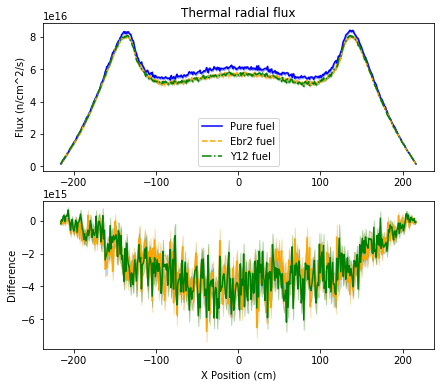

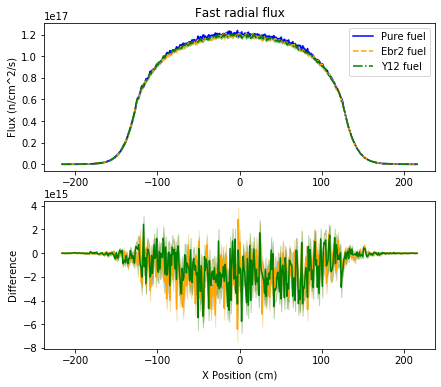

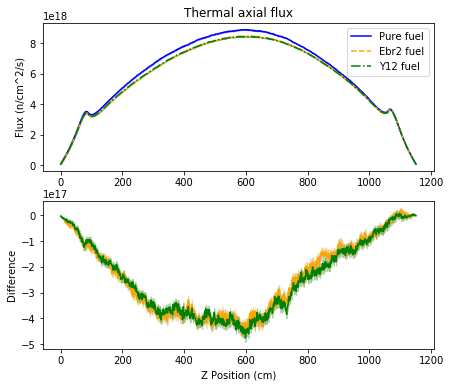

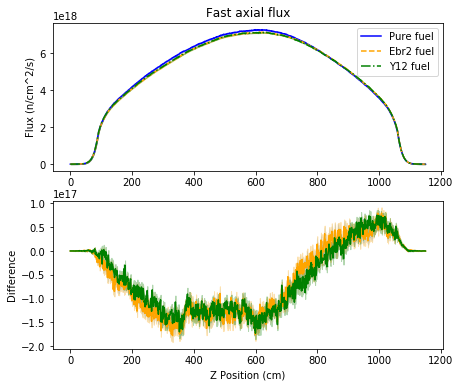

In [11]:
# Neutron flux for all base temperatures
axial_grid = np.linspace(0, 1150, 1150)
radial_grid = np.linspace(-216, 216, 432)
for fuel_index, fuel in enumerate(out_files['detectors']['2group']):
        counter = 0
        
        plt.figure(counter, figsize=(7,6))
        ax1 = plt.subplot(2,1,1)
        error = flux['radial'][fuel].errors[0, 483, 267:699]*flux['radial'][fuel].tallies[0, 483, 267:699]
        ax1.plot(radial_grid, flux['radial'][fuel].tallies[0, 483, 267:699],
                    label=f"{fuel.capitalize()} fuel", color = colors[fuel],
                linestyle = linestyles[fuel])
        ax1.fill_between(radial_grid, flux['radial'][fuel].tallies[0, 483, 267:699]-error, 
                         flux['radial'][fuel].tallies[0, 483, 267:699]+error,
                        alpha=0.3, edgecolor=colors[fuel])
        ax1.legend()
        ax1.set_ylabel("Flux (n/cm^2/s)")
        plt.title("Thermal radial flux")
        if fuel != 'pure':
            ax2 = plt.subplot(2,1,2)
            diff = flux['radial'][fuel].tallies[0, 483, 267:699] - flux['radial']['pure'].tallies[0,483,267:699]
            diff_e = error + flux['radial']['pure'].tallies[0, 483, 267:699]*flux['radial']['pure'].errors[0,483, 267:699]
            ax2.plot(radial_grid, diff, color=colors[fuel])
            ax2.fill_between(radial_grid, diff-error, diff+error, alpha = 0.3, edgecolor=colors[fuel])
            ax2.set_ylabel("Difference")
            ax2.set_xlabel('X Position (cm)')
        plt.savefig("figures/xe100_thermal_radial.pdf")
                    
        plt.figure(counter+1, figsize=(7,6))
        ax1 = plt.subplot(2,1,1)
        error = radial.errors[1, 483, 267:699]*radial.tallies[1, 483, 267:699]
        ax1.plot(radial_grid, flux['radial'][fuel].tallies[1, 483, 267:699],
                    label=f"{fuel.capitalize()} fuel", color = colors[fuel],
                linestyle = linestyles[fuel])
        ax1.fill_between(radial_grid, flux['radial'][fuel].tallies[1, 483, 267:699]-error,
                         flux['radial'][fuel].tallies[1, 483, 267:699]+error,
                        alpha=0.3, edgecolor=colors[fuel])
        ax1.legend()
        ax1.set_ylabel("Flux (n/cm^2/s)")
        plt.title("Fast radial flux")
        if fuel != 'pure':
            ax2 = plt.subplot(2,1,2)
            diff = flux['radial'][fuel].tallies[1, 483, 267:699] - flux['radial']['pure'].tallies[1,483,267:699]
            diff_e = error + flux['radial']['pure'].tallies[1, 483, 267:699]*flux['radial']['pure'].errors[1,483, 267:699]
            ax2.plot(radial_grid, diff, color=colors[fuel])
            ax2.fill_between(radial_grid, diff-error, diff+error, alpha=0.3,edgecolor=colors[fuel])
            ax2.set_ylabel("Difference")
            ax2.set_xlabel('X Position (cm)')
        plt.savefig('figures/xe100_fast_radial.pdf')
        
        plt.figure(counter+2, figsize=(7,6))
        ax1 = plt.subplot(2,1,1)
        error = flux['axial'][fuel].errors[0, :]*flux['axial'][fuel].tallies[0, :]
        ax1.plot(axial_grid, flux['axial'][fuel].tallies[0, :],
                    label=f"{fuel.capitalize()} fuel", color = colors[fuel],
                linestyle = linestyles[fuel])
        ax1.fill_between(axial_grid, flux['axial'][fuel].tallies[0, :]-error, 
                         flux['axial'][fuel].tallies[0, :]+error,
                        alpha=0.3, edgecolor=colors[fuel])
        ax1.legend()
        ax1.set_ylabel("Flux (n/cm^2/s)")
        plt.title("Thermal axial flux")
        if fuel != 'pure':
            ax2 = plt.subplot(2,1,2)
            diff = flux['axial'][fuel].tallies[0, :] - flux['axial']['pure'].tallies[0,:]
            diff_e = error + flux['axial']['pure'].tallies[0, :]*flux['axial']['pure'].errors[0,:]
            ax2.plot(axial_grid, diff, color=colors[fuel])
            ax2.fill_between(axial_grid, diff-error, diff+error,alpha=0.3, edgecolor=colors[fuel])
            ax2.set_ylabel("Difference")
            ax2.set_xlabel('Z Position (cm)')
        plt.savefig("figures/xe100_thermal_axial.pdf")
                    
        plt.figure(counter+3, figsize=(7,6))
        ax1 = plt.subplot(2,1,1)
        error = flux['axial'][fuel].errors[1, :]*flux['axial'][fuel].tallies[1, :]
        ax1.plot(axial_grid, flux['axial'][fuel].tallies[1, :],
                    label=f"{fuel.capitalize()} fuel", color = colors[fuel],
                linestyle = linestyles[fuel])
        ax1.fill_between(axial_grid, flux['axial'][fuel].tallies[1, :]-error, 
                         flux['axial'][fuel].tallies[1, :]+error,
                        alpha=0.3, edgecolor=colors[fuel])
        ax1.legend()
        ax1.set_ylabel("Flux (n/cm^2/s)")
        plt.title("Fast axial flux")
        if fuel != 'pure':
            ax2 = plt.subplot(2,1,2)
            diff = flux['axial'][fuel].tallies[1, :] - flux['axial']['pure'].tallies[1,:]
            diff_e = error + flux['axial']['pure'].tallies[1, :]*flux['axial']['pure'].errors[1,:]
            ax2.plot(axial_grid, diff, color=colors[fuel])
            ax2.fill_between(axial_grid, diff-error, diff+error,alpha=0.3, edgecolor=colors[fuel])
            ax2.set_ylabel("Difference")
            ax2.set_xlabel('Z Position (cm)')
        plt.savefig('figures/xe100_fast_axial.pdf')

### Flux Energy Spectrum

In [31]:
energy = [2.0000000000E+01, 1.7333000000E+01,1.5683000000E+01,1.4550000000E+01,
1.3840000000E+01,1.2840000000E+01,1.0000000000E+01,8.1873000000E+00,
6.4340000000E+00,4.8000000000E+00,4.3040000000E+00,3.0000000000E+00,
2.4790000000E+00,2.3540000000E+00,1.8500000000E+00,1.5000000000E+00,
1.4000000000E+00,1.3560000000E+00,1.3170000000E+00,1.2500000000E+00,
1.2000000000E+00,1.1000000000E+00,1.0100000000E+00,9.2000000000E-01,
9.0000000000E-01,8.7500000000E-01,8.6110000000E-01,8.2000000000E-01,
7.5000000000E-01,6.7900000000E-01,6.7000000000E-01,6.0000000000E-01,
5.7300000000E-01,5.5000000000E-01,4.9952000000E-01,4.7000000000E-01,
4.4000000000E-01,4.2000000000E-01,4.0000000000E-01,3.3000000000E-01,
2.7000000000E-01,2.0000000000E-01,1.5000000000E-01,1.2830000000E-01,
1.0000000000E-01,8.5000000000E-02,8.2000000000E-02,7.5000000000E-02,
7.3000000000E-02,6.0000000000E-02,5.2000000000E-02,5.0000000000E-02,
4.5000000000E-02,3.0000000000E-02,2.5000000000E-02,1.7000000000E-02,
1.3000000000E-02,9.5000000000E-03,8.0300000000E-03,6.0000000000E-03,
3.9000000000E-03,3.7400000000E-03,3.0000000000E-03,2.5800000000E-03,
2.2900000000E-03,2.2000000000E-03,1.8000000000E-03,1.5500000000E-03,
1.5000000000E-03,1.1500000000E-03,9.5000000000E-04,6.8300000000E-04,
6.7000000000E-04,5.5000000000E-04,3.0500000000E-04,2.8500000000E-04,
2.4000000000E-04,2.1000000000E-04,2.0750000000E-04,1.9250000000E-04,
1.8600000000E-04,1.2200000000E-04,1.1900000000E-04,1.1500000000E-04,
1.0800000000E-04,1.0000000000E-04,9.0000000000E-05,8.2000000000E-05,
8.0000000000E-05,7.6000000000E-05,7.2000000000E-05,6.7500000000E-05,
6.5000000000E-05,6.1000000000E-05,5.9000000000E-05,5.3400000000E-05,
5.2000000000E-05,5.0600000000E-05,4.9200000000E-05,4.8300000000E-05,
4.7000000000E-05,4.5200000000E-05,4.4000000000E-05,4.2400000000E-05,
4.1000000000E-05,3.9600000000E-05,3.9100000000E-05,3.8000000000E-05,
3.7000000000E-05,3.5500000000E-05,3.4600000000E-05,3.3750000000E-05,
3.3250000000E-05,3.1750000000E-05,3.1250000000E-05,3.0000000000E-05,
2.7500000000E-05,2.5000000000E-05,2.2500000000E-05,2.1000000000E-05,
2.0000000000E-05,1.9000000000E-05,1.8500000000E-05,1.7000000000E-05,
1.6000000000E-05,1.5100000000E-05,1.4400000000E-05,1.3750000000E-05,
1.2900000000E-05,1.1900000000E-05,1.1500000000E-05,1.0000000000E-05,
9.1000000000E-06,8.1000000000E-06,7.1500000000E-06,7.0000000000E-06,
6.7500000000E-06,6.5000000000E-06,6.2500000000E-06,6.0000000000E-06,
5.4000000000E-06,5.0000000000E-06,4.7500000000E-06,4.0000000000E-06,
3.7300000000E-06,3.5000000000E-06,3.1500000000E-06,3.0500000000E-06,
3.0000000000E-06,2.9700000000E-06,2.8700000000E-06,2.7700000000E-06,
2.6700000000E-06,2.5700000000E-06,2.4700000000E-06,2.3800000000E-06,
2.3000000000E-06,2.2100000000E-06,2.1200000000E-06,2.0000000000E-06,
1.9400000000E-06,1.8600000000E-06,1.7700000000E-06,1.6800000000E-06,
1.5900000000E-06,1.5000000000E-06,1.4500000000E-06,1.4000000000E-06,
1.3500000000E-06,1.3000000000E-06,1.2500000000E-06,1.2250000000E-06,
1.2000000000E-06,1.1750000000E-06,1.1500000000E-06,1.1400000000E-06,
1.1300000000E-06,1.1200000000E-06,1.1100000000E-06,1.1000000000E-06,
1.0900000000E-06,1.0800000000E-06,1.0700000000E-06,1.0600000000E-06,
1.0500000000E-06,1.0400000000E-06,1.0300000000E-06,1.0200000000E-06,
1.0100000000E-06,1.0000000000E-06,9.7500000000E-07,9.5000000000E-07,
9.2500000000E-07,9.0000000000E-07,8.5000000000E-07,8.0000000000E-07,
7.5000000000E-07,7.0000000000E-07,6.5000000000E-07,6.2500000000E-07,
6.0000000000E-07,5.5000000000E-07,5.0000000000E-07,4.5000000000E-07,
4.0000000000E-07,3.7500000000E-07,3.5000000000E-07,3.2500000000E-07,
3.0000000000E-07,2.7500000000E-07,2.5000000000E-07,2.2500000000E-07,
2.0000000000E-07,1.7500000000E-07,1.5000000000E-07,1.2500000000E-07,
1.0000000000E-07,9.0000000000E-08,8.0000000000E-08,7.0000000000E-08,
6.0000000000E-08,5.0000000000E-08,4.0000000000E-08,3.0000000000E-08,
2.5300000000E-08,1.0000000000E-08,7.5000000000E-09,5.0000000000E-09,
4.0000000000E-09,3.0000000000E-09,2.5000000000E-09,2.0000000000E-09,
1.5000000000E-09,1.2000000000E-09,1.0000000000E-09,7.5000000000E-10,
5.0000000000E-10,1.0000000000E-10,1.0000000000E-11]
energy.reverse()

In [32]:
lethargy = []
for ii in range(1, 239):
    lethargy.append(math.log(energy[ii]/energy[ii-1]))

In [ ]:
spectrum = {'pure':0, 'ebr2':0, 'y12':0}

In [39]:
for fuel in ['y12']:
    detector = serpentTools.read(out_files['detectors']['mg'][fuel], 'det')
    spectrum[fuel] = detector.detectors['radial_flux']

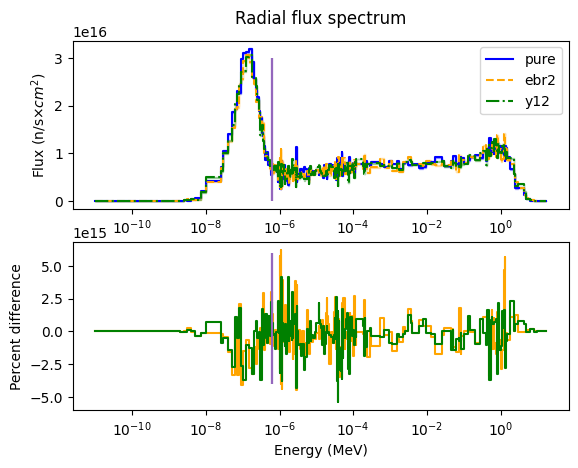

In [40]:
# Flux specturm in the middle of core
x_pos = 483
y_pos = 483
z_pos = 575
for fuel in out_files['detectors']['mg']:
        counter = 0

      
        plt.figure(1)
        ax1 = plt.subplot(2,1,1)
        y  = spectrum[fuel].tallies[:,x_pos, y_pos]/lethargy
        ax1.step(energy[:-1], y, label=fuel,
                color=colors[fuel], linestyle = linestyles[fuel])
        error = spectrum[fuel].errors[:,y_pos, x_pos]*spectrum[fuel].tallies[:,y_pos, x_pos]
        ax1.fill_between(energy[:-1], y-error,
                        y+error, alpha=0.3,
                        edgecolor=colors[fuel], facecolor=colors[fuel], step='pre')
        plt.xscale('log')
        #plt.yscale('log')
        ax2 = plt.subplot(2,1,2)
        if fuel != 'pure':
            diff = y-spectrum['pure'].tallies[:,y_pos, x_pos]/lethargy
            diff_e = np.sqrt((spectrum[fuel].errors[:,y_pos, x_pos]*spectrum[fuel].tallies[:,y_pos, x_pos])**2 + \
                     (spectrum['pure'].errors[:,y_pos, x_pos]*spectrum['pure'].tallies[:,y_pos, x_pos])**2)
            ax2.step(energy[:-1], diff, color=colors[fuel])
            #ax2.fill_between(energy, diff-diff_e, diff+diff_e, step='pre',
            #                alpha=0.3, edgecolor=colors[fuel], 
            #                facecolor=colors[fuel])
        ax2.set_xlabel('Energy (MeV)')
        ax1.set_ylabel(r'Flux (n/s$\times cm^2$)')
        ax2.set_ylabel('Percent difference')
        ax1.set_title(f"Radial flux spectrum", y=1.05)
        ax1.legend()
        ax1.vlines(0.625e-6, 0, 3e16, 'tab:purple')
        ax2.vlines(0.625e-6, -4e15, 6e15, 'tab:purple')
        
        plt.xscale('log')
        #plt.yscale('log')
        
        plt.savefig('xe100_spectrum_center.png')

In [41]:
core_flux = {'pure':np.zeros(238), 'ebr2':np.zeros(238), 'y12':np.zeros(238)}
for fuel in core_flux:
    for x in range(0, 966):
        for y in range(0, 966):
            core_flux[fuel] += spectrum[fuel].tallies[:, x, y]

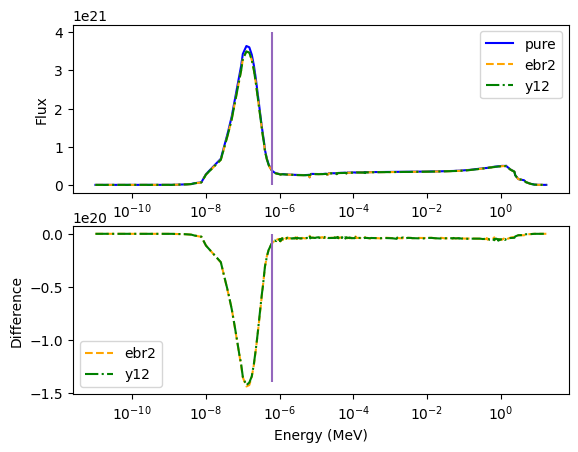

In [61]:
plt.figure()
ax1 = plt.subplot(2,1,1)
for fuel in core_flux:
    ax1.plot(energy[:-1], core_flux[fuel]/lethargy, label=fuel, color=colors[fuel],
            linestyle=linestyles[fuel])
ax1.vlines(0.625e-6, 0, 4e21, 'tab:purple')
plt.legend()
plt.xlabel('Energy (MeV)')
plt.ylabel('Flux')
plt.xscale('log')
#plt.yscale('log')

ax2 = plt.subplot(2,1,2)
for fuel in ['ebr2', 'y12']:
    ax2.plot(energy[:-1], (core_flux[fuel]-core_flux['pure'])/lethargy, 
             color = colors[fuel], label=fuel, linestyle=linestyles[fuel])
ax2.vlines(0.625e-6, -1.4e20, 1, 'tab:purple')
#ax2.set_yscale('log')
plt.legend()
plt.xlabel('Energy (MeV)')
plt.ylabel('Difference')
plt.xscale('log')
plt.savefig('xe100_mg_flux.pdf')

## Temperature feedback coefficients

In [12]:
rho = {'pure':{},'ebr2':{}, 'y12':{}}
rho_error = {'pure':{}, 'ebr':{}, 'y12':{}}
feedback = {'pure':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0},
             'ebr2':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}, 
             'y12':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}}
feedback_error = {'pure':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0},
             'ebr2':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}, 
             'y12':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}}
for key in rho:
    rho[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}
    rho_error[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}
for fuel in out_files['results']: 
    for key in rho[fuel]:
        rho[fuel][key] = calculate_rho(k_eff[fuel][key])

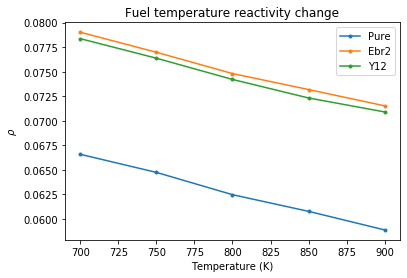

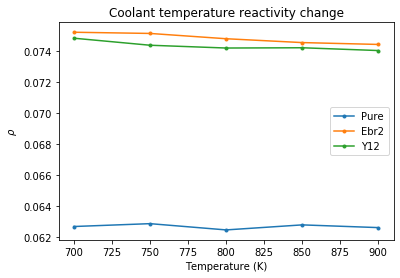

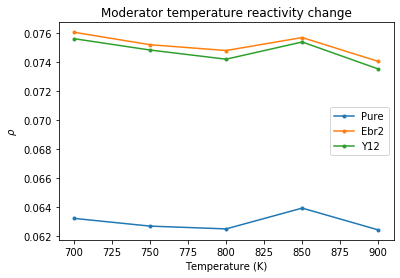

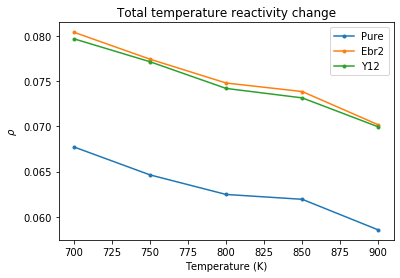

In [13]:
temps = [700, 750, 800, 850, 900]
for fuel in out_files['results']:
    for m_index, material in enumerate(['fuel', 'coolant', 'moderator', 'total']):
        plt.figure(m_index)
        if material == 'fuel':
            data =[rho[fuel]['ACC'], rho[fuel]['BCC'], rho[fuel]['CCC'], rho[fuel]['DCC'], rho[fuel]['ECC']]
        if material == 'coolant':
            data =[rho[fuel]['CAC'], rho[fuel]['CBC'], rho[fuel]['CCC'], rho[fuel]['CDC'], rho[fuel]['CEC']]
        if material == 'moderator':
            data =[rho[fuel]['CCA'], rho[fuel]['CCB'], rho[fuel]['CCC'], rho[fuel]['CCD'], rho[fuel]['CCE']]
        if material == 'total':
            data =[rho[fuel]['AAA'], rho[fuel]['BBB'], rho[fuel]['CCC'], rho[fuel]['DDD'], rho[fuel]['EEE']]
        feedback[fuel][material] = calculate_m(temps, data)
        feedback_error[fuel][material] = calculate_m_error(temps, data)
        
        plt.plot(temps, data, 
                 marker='.', label=f"{fuel.capitalize()}")
        plt.legend()
        plt.title(f"{material.capitalize()} temperature reactivity change")
        plt.xlabel('Temperature (K)')
        plt.ylabel(r'$\rho$')

In [14]:
for fuel in feedback:
    for material in feedback[fuel]:
        print(fuel, material, feedback[fuel][material]*1e5, "+/-",
             feedback_error[fuel][material]*1e5)

pure fuel -3.8757447608410076 +/- 0.09381354383189565
pure coolant -0.04392495760421298 +/- 0.11166541112604249
pure moderator -0.07052716505222634 +/- 0.45940021513006596
pure total -4.216290169633794 +/- 0.5024161990604549
ebr2 fuel -3.759387662914923 +/- 0.13826332077665815
ebr2 coolant -0.4330939424316967 +/- 0.047623265128786306
ebr2 moderator -0.7084394229255849 +/- 0.4042949151293861
ebr2 total -4.816705613401791 +/- 0.43820452094877677
y12 fuel -3.797298064501047 +/- 0.15680539530755933
y12 coolant -0.3512356301143882 +/- 0.09183310691739292
y12 moderator -0.7280664691454148 +/- 0.4693044895810008
y12 total -4.700107866113285 +/- 0.34864364627715966


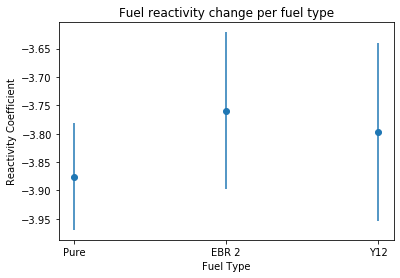

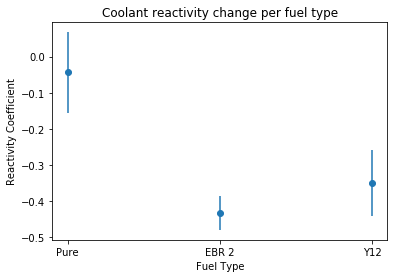

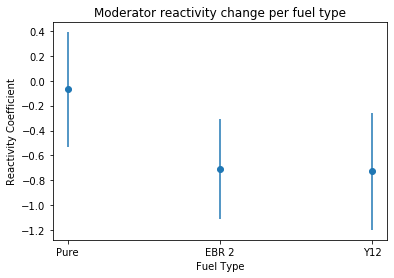

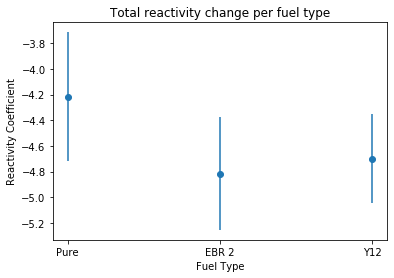

In [15]:
for m_index, material in enumerate(feedback['pure']):
    plt.figure(m_index)
    plt.errorbar(['Pure', 'EBR 2', 'Y12'], [feedback['pure'][material]*1e5, 
                                            feedback['ebr2'][material]*1e5, 
                                            feedback['y12'][material]*1e5],
                yerr = [feedback_error['pure'][material]*1e5, 
                        feedback_error['ebr2'][material]*1e5,
                        feedback_error['y12'][material]*1e5],
                linestyle='None', marker = 'o')
    plt.xlabel('Fuel Type')
    plt.ylabel('Reactivity Coefficient')
    plt.title(f'{material.capitalize()} reactivity change per fuel type')